In [45]:
%load_ext autoreload
%autoreload 2

import pandas as pd

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from data_retriever import DataRetriever
from data_preprocessor import DataPreprocessor
from metrics import r_squared, rmse, nrmse, mape, smape
from model import BayesianModel
from visualization import attribution_plot
from saturation import Saturation
from adstock import Adstock

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# Config
PATH_TO_DB = './data.db'
TARGET = 'revenue'
MEDIA_VARIABLES = [
    'tv_S', 
    'ooh_S', 
    'print_S', 
    'search_S', 
    'facebook_S', 
    'newsletter'
]
CONTROL_VARIABLES = (
    ['competitor_sales_B', 'event1', 'event2']
)

In [47]:
# Data 
dr = DataRetriever(
    db=PATH_TO_DB,
    start_dt=datetime.fromisoformat('2015-11-23'),
    end_dt=datetime.fromisoformat('2019-11-11')
)
data = dr.retrieve()

In [48]:
# Preprocessing
dp = DataPreprocessor(data, MEDIA_VARIABLES, CONTROL_VARIABLES, TARGET)
X, y = dp.compute_X_y()

In [49]:
# Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=0, 
    shuffle=False, 
    test_size=0.2
)
scaler = MinMaxScaler(clip=True)
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
X_train.loc[:, MEDIA_VARIABLES] = X_train.loc[:, MEDIA_VARIABLES].replace(0, 1e-5)
X_test.loc[:, MEDIA_VARIABLES] = X_test.loc[:, MEDIA_VARIABLES].replace(0, 1e-5)

In [50]:
# Bayesian model
model = BayesianModel(
    media_variables=MEDIA_VARIABLES, 
    control_variables=CONTROL_VARIABLES,
    fit_intercept=True
)
model.fit(X_train, y_train)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, beta_event2, beta_event1, beta_competitor_sales_B, n_newsletter, k_newsletter, theta_newsletter, beta_newsletter, n_facebook_S, k_facebook_S, theta_facebook_S, beta_facebook_S, n_search_S, k_search_S, theta_search_S, beta_search_S, n_print_S, k_print_S, theta_print_S, beta_print_S, n_ooh_S, k_ooh_S, theta_ooh_S, beta_ooh_S, n_tv_S, k_tv_S, theta_tv_S, beta_tv_S, intercept]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 16 seconds.


In [51]:
# Performance metrics
performance_metrics = []
y_test_hat = model.predict(X_test)
metrics_test = {
    'model': f'{model.__class__.__name__}',
    'dataset': 'test',
    'r_squared': r_squared(y_test, y_test_hat),
    'rmse': rmse(y_test, y_test_hat),
    'nrmse': nrmse(y_test, y_test_hat),
    'mape': mape(y_test, y_test_hat),
    'smape': smape(y_test, y_test_hat),
}
performance_metrics.append(metrics_test)
y_train_hat = model.predict(X_train)
metrics_train = {
    'model': f'{model.__class__.__name__}',
    'dataset': 'train',
    'r_squared': r_squared(y_train, y_train_hat),
    'rmse': rmse(y_train, y_train_hat),
    'nrmse': nrmse(y_train, y_train_hat),
    'mape': mape(y_train, y_train_hat),
    'smape': smape(y_train, y_train_hat), 
}
performance_metrics.append(metrics_train)
performance_metrics = pd.DataFrame(performance_metrics)
performance_metrics

,model,dataset,r_squared,rmse,nrmse,mape,smape
0,BayesianModel,test,0.667250,0.376449,0.179643,0.280550,0.233833
1,BayesianModel,train,0.783221,0.334896,0.108022,0.163914,0.154779


In [52]:
model.coefficients

{'tv_S': 0.6125580721836984,
 'ooh_S': 0.3077157909708874,
 'print_S': 0.3599107416956507,
 'search_S': 0.6085735462886596,
 'facebook_S': 0.5628230494584154,
 'newsletter': 0.5480320921459427,
 'competitor_sales_B': 0.9340903598301765,
 'event1': 0.5371863253223903,
 'event2': 0.2824238930572468,
 'intercept': 0.783458326755384}

In [53]:
model.posterior_params

{'tv_S_k': 0.2794243097034522,
 'tv_S_n': 1.4893601031666104,
 'tv_S_theta': 0.25114388079946476,
 'ooh_S_k': 1.4487035710952891,
 'ooh_S_n': 0.8631154932114745,
 'ooh_S_theta': 0.2490263111908387,
 'print_S_k': 1.3268117022149641,
 'print_S_n': 0.8375488401079663,
 'print_S_theta': 0.2571422485031652,
 'search_S_k': 0.5180731731244141,
 'search_S_n': 2.630584994832371,
 'search_S_theta': 0.26483296016524616,
 'facebook_S_k': 0.5342454344964257,
 'facebook_S_n': 1.0483118612084044,
 'facebook_S_theta': 0.24738309839225694,
 'newsletter_k': 0.8805203282383616,
 'newsletter_n': 0.5582563039905288,
 'newsletter_theta': 0.2536499420909709}

In [54]:
# Attribution
variables = MEDIA_VARIABLES + CONTROL_VARIABLES
attribution_df = X_test.copy()

for var in MEDIA_VARIABLES:
    adstock = Adstock(theta=model.posterior_params[f"{var}_theta"])
    attribution_df[var] = adstock.fit_transform(attribution_df[[var]])
    
saturation = Saturation(
    col_0_k = model.posterior_params['tv_S_k'],
    col_0_n = model.posterior_params['tv_S_n'],
    col_1_k = model.posterior_params['ooh_S_k'],
    col_1_n = model.posterior_params['ooh_S_n'],
    col_2_k = model.posterior_params['print_S_k'],
    col_2_n = model.posterior_params['print_S_n'],
    col_3_k = model.posterior_params['search_S_k'],
    col_3_n = model.posterior_params['search_S_n'],
    col_4_k = model.posterior_params['facebook_S_k'],
    col_4_n = model.posterior_params['facebook_S_n'],
    col_5_k = model.posterior_params['newsletter_k'],
    col_5_n = model.posterior_params['newsletter_n'],
)
saturation.fit(attribution_df[MEDIA_VARIABLES])
attribution_df[MEDIA_VARIABLES] = saturation.transform(attribution_df[MEDIA_VARIABLES])

for var in variables:
    attribution_df[var] = model.coefficients[var] * attribution_df[var]

attribution_df["intercept"] = model.coefficients['intercept']
organic_columns = CONTROL_VARIABLES+['intercept']
attribution_df['organic'] = attribution_df[organic_columns].sum(axis=1)
attribution_df.drop(organic_columns, axis=1, inplace=True)

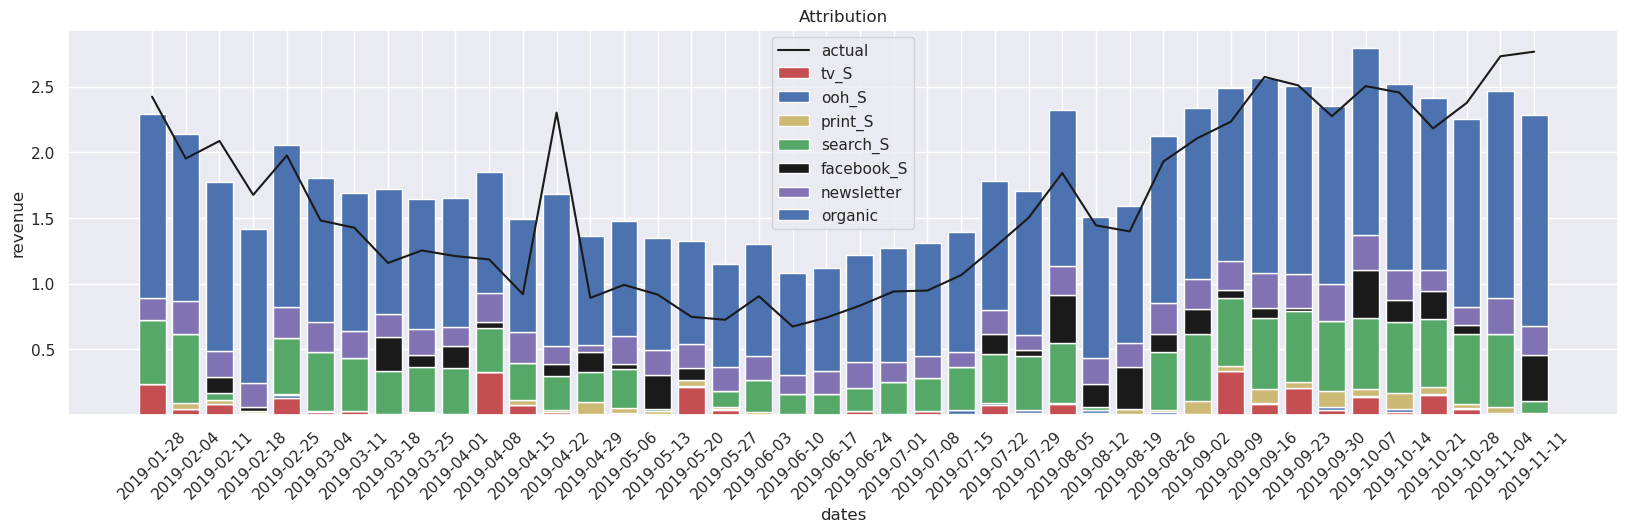

In [55]:
# Plot
attribution_plot(
    attribution_df, 
    TARGET, 
    data.loc[data.index.isin(attribution_df.index), 'revenue']
)